<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#FASTQ-format" data-toc-modified-id="FASTQ-format-0.1">FASTQ format</a></span></li><li><span><a href="#Quality-check-before-mapping" data-toc-modified-id="Quality-check-before-mapping-0.2">Quality check before mapping</a></span><ul class="toc-item"><li><span><a href="#Check-restriction-enzyme-used" data-toc-modified-id="Check-restriction-enzyme-used-0.2.1">Check restriction-enzyme used</a></span></li><li><span><a href="#Plot-PHRED-score-and-ligation/digestion-sites" data-toc-modified-id="Plot-PHRED-score-and-ligation/digestion-sites-0.2.2">Plot PHRED score and ligation/digestion sites</a></span></li></ul></li></ul></li></ul></div>

## FASTQ format

The file is organized in 4 lines per read:
 1. starting with `@`, the header of the DNA sequence with the read id (plus optional fields)
 2. the DNA sequence
 3. starting with `+`, the header of the sequence quality (this line could be either a repetition of first line or empty)
 4. the sequence quality (it is not human readble, but is provided as PHRED score. Check   https://en.wikipedia.org/wiki/Phred_quality_score for more details)

In [1]:
%%bash 

dsrc d -s FASTQs/mouse_B_rep1_1.fastq.dsrc | head -n 8

@SRR5344921.1
ACCACTGATGGCACCACTGTTGTACTTTAGGATCGATCACTCCTTATACGCACATAGGAAACACTGACTAGAGGG
+
@B@B@>1>=;1@EG0B0;1=E1:>>1111<?=1E9=0><C:<>11=11?1=ECDC1>1=@FD1<:1?C#######
@SRR5344921.2
GGGCTTTTTTTGGCTGGGAGACTATTTATAACTGCTTCTATTTCTTTAGGGGATATGGGACTGTTTAGAAGGTCA
+
BCCBBFGGGG@GEGGGGDGEBGEF@<1FGGEFGGECGG@FEGGGEG>@1=09/BFGGEG111C<F1>11BGF1=1


Count the number of lines in the file (4 times the number of reads)

In [2]:
%%bash

dsrc d -s FASTQs/mouse_B_rep1_1.fastq.dsrc | wc -l

400000000


There are 400 M lines in the file, which means 100M reads in total.

## Quality check before mapping

### Check restriction-enzyme used

Most important to analyze HiC dataset is the restriction enzyme used in the experiment. TADbit provides a simple function to check for it:

In [3]:
from pytadbit.mapping.restriction_enzymes import identify_re

In [4]:
pat, enz, pv = identify_re('FASTQs/mouse_B_rep1_1.fastq.dsrc')

print '- Most probable pattern: %s, matching enzymes: %s' % (pat, ','.join(enz))

- Most probable pattern: GATC, matching enzymes: BssMI,DpnII,Sau3AI,MboI,Kzo9I,Bsp143I,NdeII,BstMBI,BfuCI


### Plot PHRED score and ligation/digestion sites

In order to quickly assess the quality of the HiC experiment (before mapping), and given that we know the restriction enzyme used, we can check the proportion of reads with ligation sites as well as the number of reads starting by a cut-site.

These numbers will give us a first hint on the __efficiencies of two critical steps in the HiC experiment, the digestion and the ligation.__

In [5]:
from pytadbit.utils.fastq_utils import quality_plot

In [6]:
r_enz = 'MboI'

In [7]:
cell = 'B'
repl = 'rep1'

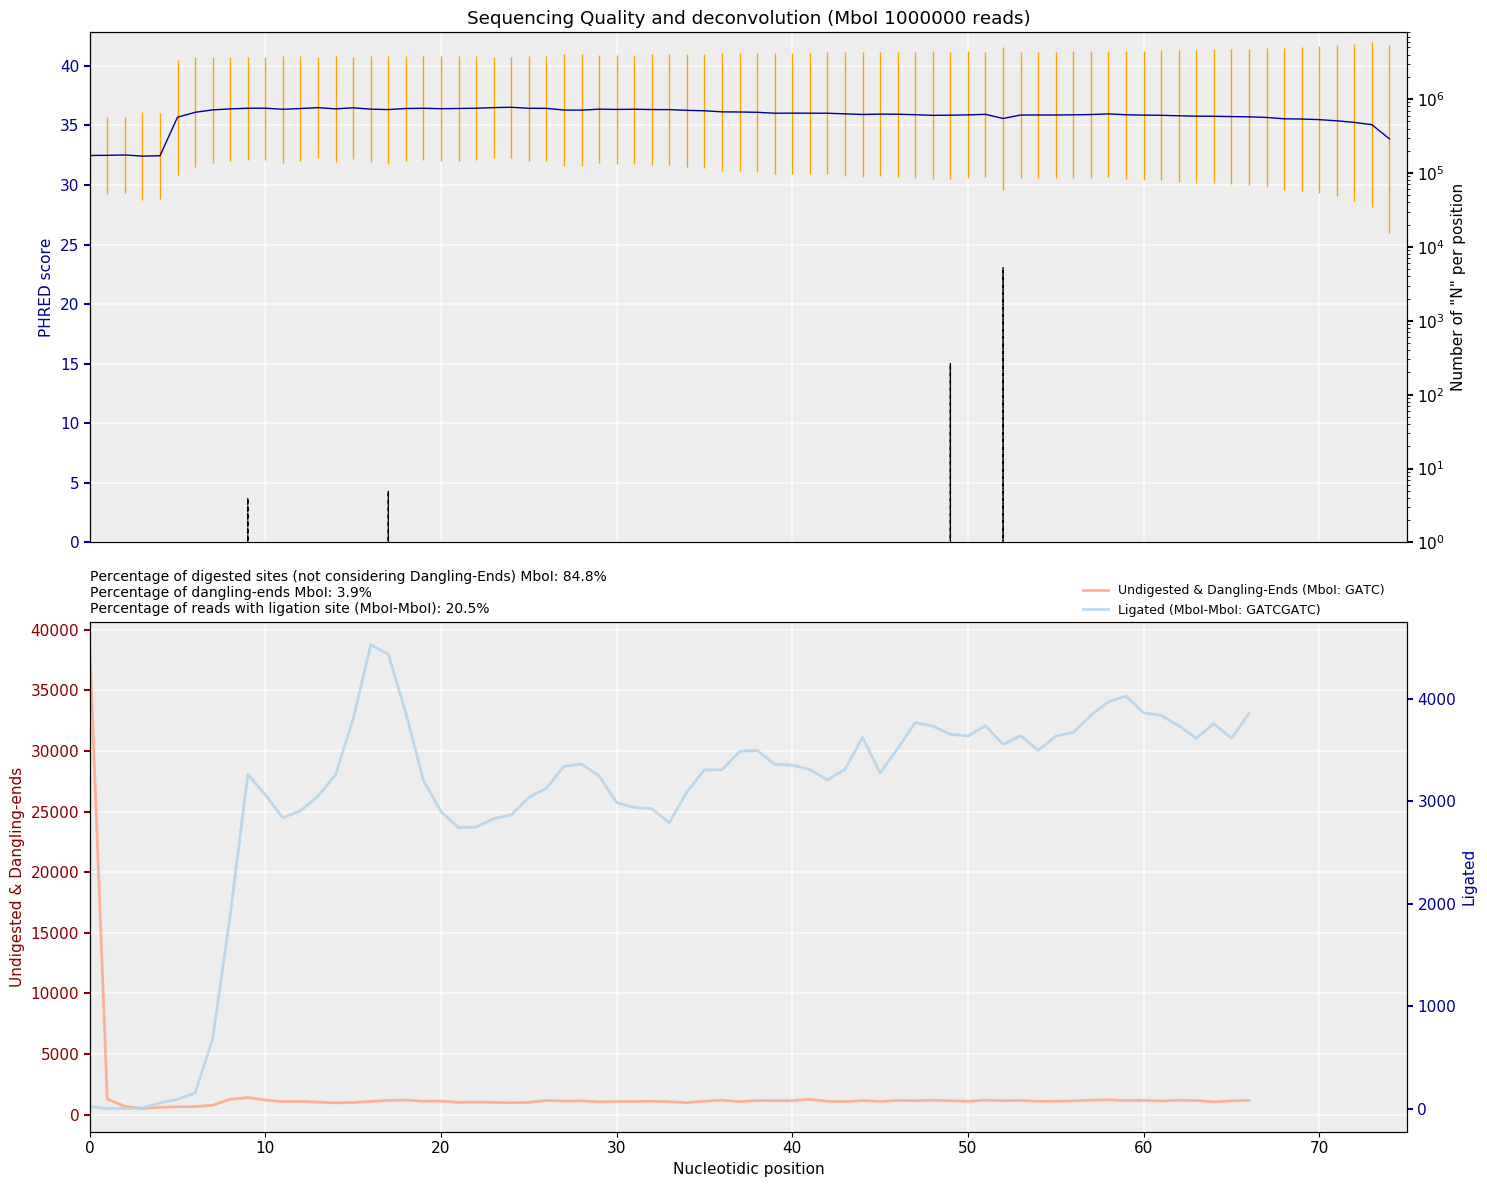

({'MboI': 3.8757}, {('MboI', 'MboI'): 20.5069})

In [10]:
quality_plot('FASTQs/mouse_{0}_{1}_1.fastq.dsrc'.format(cell, repl), r_enz=r_enz, nreads=1000000)

The plot on the top represents the typical per nucleotide quality profile of NGS reads, with, in addition, the proportion of `N` found at each position. 

The second plot, is specific to Hi-C experiments. Given a restriction enzyme the function searches for the presence of ligation sites and of undigested restriction enzyme sites. Depending on the enzyme used the function can differentiate between dangling-ends and undigested sites.

Both plots are done over the first million reads, as this is usually enough to asses the general quality of the sequencing.

From these proportions some quality statistics can be inferred before mapping:
- The __percentage of digested sites__ which is the ratio of digested over undigested sites found over the reads analyzed. Expected to be above 60%.
- The __percentage of dangling-ends__ which is the number of time a digested site is found at the beginning of a read. Expected to be __between 1% and 10%__.
- The __percentage of ligation sites__ which is the number of times a ligation site is found in the processed reads, expected to be __above 15%__ for read length of 75 nt and sequenced fragment size ~300 nt. This number has to be transform to reflect the reality as it corresponds only to the sequenced part of the DNA fragment. For example, in this case, if the mean fragment size is 300 nucleotides and we found that 20.5% of the reads presenting (at least) 1 ligation site. Given that our search space for this set of reads is 67 nucleotides (read length is 75, minus the size of the patten `GATCGATC`), and given that we should have a constant number of ligation sites in all the fragment, we would expect to find a ligation site in 92% of the reads. Usually we expect to have more than 75%.

_Note: this plot is __compatible with the use of multiple restriction enzymes__ (which is why the ligation site is labeled as MboI-MboI)_